# Histogram with edges only

The histogram is a non parametric method to estimate the probability density function of a random variable given a sample. When the sample is large, the histogram produced by OpenTURNS is filled with unnecessary colors. Moreover, we cannot easily represent several histograms on the same plot. Finally, when we export the figure into a file, the vector image (e.g. SVG or PDF) can be relatively large and difficult to annotate or modify manually because of the large number of graphical objects within the figure. 

In this example, we implement a `SuperHistogram` class which represents only the edges of the histogram. This represents the PDF of the histogram as a function which is constant on each class. Hence, there is much less used colors when the sample size is large. Furthermore, we can plot several histograms on the same plot. This allows, for example, to plot confidence intervals of the PDF estimator on the same plot as the histogram itself. 

In [1]:
import openturns as ot
import openturns.viewer as otv
import numpy as np

We generate a very large sample from the gaussian distribution. Then we build the histogram estimator from the sample. Finally, we plot the PDF of the histogram. 

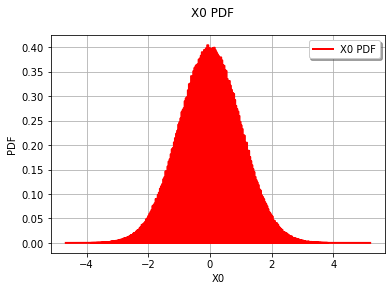

In [2]:
size = 1000000
distribution = ot.Normal()
sample = distribution.getSample(size)

histogram = ot.HistogramFactory().buildAsHistogram(sample)
graph = histogram.drawPDF()
view = otv.View(graph)

In [4]:
class SuperHistogram:
    def __init__(self, histogram, verbose=False):
        """
        An histogram with enhanced drawPDF method.

        Parameters
        ----------
        histogram : ot.Histogram
            The base histogram.
        verbose : bool, optional
            If True, print intermediate messages. The default is False.

        Returns
        -------
        None.

        """
        self.histogram = histogram
        self.verbose = verbose

    def drawPDF(self):
        """
        Plot the PDF of the histogram using edges only.

        Returns
        -------
        graph : ot.Graph
            The plot.

        """
        width = self.histogram.getWidth()
        height = self.histogram.getHeight()
        first = self.histogram.getFirst()
        number_of_classes = len(width)
        if self.verbose:
            print("number_of_classes = ", number_of_classes)
        histogram_edges = ot.Sample(4 + 2 * number_of_classes, 2)
        # First edge: horizontal
        half_first_width = width[0] / 2.0
        histogram_edges[0] = [first - half_first_width, 0.0]
        if self.verbose:
            print("Add :", histogram_edges[0])
        histogram_edges[1] = [first, 0.0]
        if self.verbose:
            print("Add :", histogram_edges[1])
        i = 2
        x = first
        for index in range(number_of_classes):
            if self.verbose:
                print("Class #", index)
            histogram_edges[i] = [x, height[index]]
            if self.verbose:
                print("Add :", histogram_edges[i])
            histogram_edges[i + 1] = [x + width[index], height[index]]
            if self.verbose:
                print("Add :", histogram_edges[i + 1])
            x += width[index]
            i += 2
        # Last edge: horizontal
        half_last_width = width[-1] / 2.0
        histogram_edges[i] = [x, 0.0]
        if self.verbose:
            print("Add :", histogram_edges[i])
        i += 1
        histogram_edges[i] = [x + half_last_width, 0.0]
        if self.verbose:
            print("Add :", histogram_edges[i])
        description = self.histogram.getDescription()
        graph = ot.Graph("", description[0], "PDF", True)
        curve = ot.Curve(histogram_edges)
        graph.add(curve)
        return graph

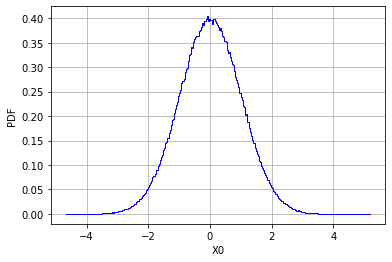

In [5]:
su_histogram = SuperHistogram(histogram)
graph = su_histogram.drawPDF()
view = otv.View(graph)

We see that only edges are represented in this plot. In order to better compare the two options, we plot the two histograms on the same graph. 

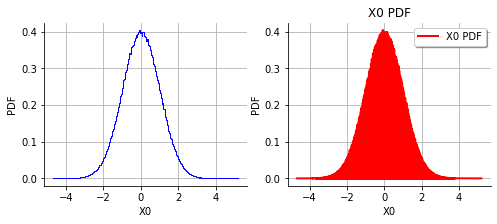

In [6]:
grid = ot.GridLayout(1, 2)
graph = su_histogram.drawPDF()
grid.setGraph(0, 0, graph)
histogram = ot.HistogramFactory().buildAsHistogram(sample)
graph = histogram.drawPDF()
grid.setGraph(0, 1, graph)
view = otv.View(grid, figure_kw={"figsize": (8.0, 3.0)})

We would like to see how the method performs when the class width changes. To do this, we compare three histograms with different class width and plot them on the same graph. 

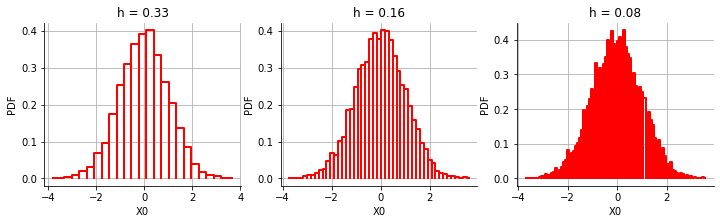

In [7]:
size = 10000
distribution = ot.Normal()
sample = distribution.getSample(size)

factory = ot.HistogramFactory()
classwidth = factory.computeBandwidth(sample)
classwidth_list = [2.0 * classwidth, classwidth, classwidth / 2.0]
number_of_class_widths = len(classwidth_list)
grid = ot.GridLayout(1, number_of_class_widths)
for index in range(number_of_class_widths):
    classwidth = classwidth_list[index]
    histogram = factory.buildAsHistogram(sample, classwidth)
    graph = histogram.drawPDF()
    graph.setLegends([""])
    graph.setTitle("h = %.2f" % (classwidth))
    grid.setGraph(0, index, graph)
view = otv.View(grid, figure_kw={"figsize": (12.0, 3.0)})

We see why the histogram seems to be filled with colors. In fact, the vertical edges of the histogram get so close to one another that they create a visually filled area.

Let us see what happens when we plot only the edges.

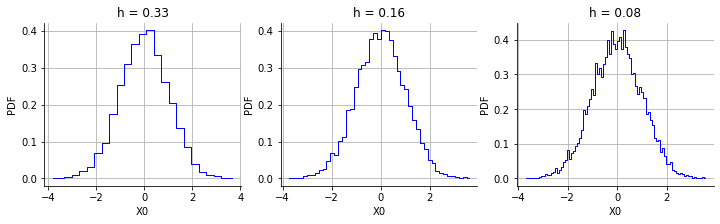

In [8]:
factory = ot.HistogramFactory()
classwidth = factory.computeBandwidth(sample)
classwidth_list = [2.0 * classwidth, classwidth, classwidth / 2.0]
number_of_class_widths = len(classwidth_list)
grid = ot.GridLayout(1, number_of_class_widths)
for index in range(number_of_class_widths):
    classwidth = classwidth_list[index]
    histogram = factory.buildAsHistogram(sample, classwidth)
    su_histogram = SuperHistogram(histogram)
    graph = su_histogram.drawPDF()
    graph.setLegends([""])
    graph.setTitle("h = %.2f" % (classwidth))
    grid.setGraph(0, index, graph)
view = otv.View(grid, figure_kw={"figsize": (12.0, 3.0)})

We see that the graph is much clearer and let us focus on the important topic, which is the estimation of the density by the histogram. 

## Conclusion

This option could be implemented as an option of the current `drawPDF()` method of the `Histogram` class. The extra boolean argument `plotEdges` would allow to control the way the histogram is drawn:
- `plotEdges = True` is the current behaviour,
- `plotEdges = False` does not plot the edges.

We have to select what is the default behaviour of the `drawPDF()` when no `plotEdges` argument is explicitly provided. This option could be set to `False` by default, so that the current behaviour is unchanged. Another implementation could compute the `plotEdges` option depending on the sample size:
- if the number of classes is, say, smaller than 20, then `plotEdges = True` ;
- otherwise, then `plotEdges = False`.


The previous behaviour would allow to automatically switch to a visually consistent graph when the sample size increases. 